In [39]:
import torch
import time
from torch.nn import functional as F
from modules.kernels import *
device= 'cuda:0'

psf= impulse(side_len=5)

def forward_model_singleH(X, Ht): #X: (m, 1, Nx, Ny), Ht: (1, 1, Nx, Ny), sPSF: (N1, N1), exPSF: (N2, N2)
    sPSF= psf.to(device)
    exPSF= psf.to(device)
    emPSF= psf.to(device)

    padding_spsf = (sPSF.shape[0]-1)//2
    padding_expsf = (exPSF.shape[0]-1)//2
    padding_empsf = (emPSF.shape[0]-1)//2

    sPSF= sPSF.view(1, 1, sPSF.shape[0], sPSF.shape[1]) 
    exPSF= exPSF.view(1, 1, exPSF.shape[0], exPSF.shape[1])
    emPSF= emPSF.view(1, 1, emPSF.shape[0], emPSF.shape[1])

    A1= F.conv2d(Ht, exPSF, padding= padding_expsf)*X
    A2= F.conv2d(A1, sPSF, padding= padding_spsf)
    yt= F.conv2d(A2, emPSF, padding= padding_empsf)
    return yt

def compute_yt(X, H, device):    
    lambda_up= torch.zeros((X.shape[0], H.shape[1], X.shape[2], X.shape[3])).to(device)
    for t in range(H.shape[1]):
        lambda_up[:, t:t+1, :, :]= forward_model_singleH(X, H[:,t:t+1,:,:])
    return lambda_up

In [40]:
def special_Conv2d(X, filter_, padding): #X.shape: (b, T, m, m), filter.shape: (1, 1, f, f)
    b, T, m, _ = X.shape
    out = F.conv2d(X.reshape(b*T, 1, m, m), filter_, padding= padding)
    return out.reshape(b, T, m, m)

def forward_model_allH(X, Ht): #X: (m, 1, Nx, Ny), Ht: (1, T, Nx, Ny), sPSF: (N1, N1), exPSF: (N2, N2)
    sPSF= psf.to(device)
    exPSF= psf.to(device)
    emPSF= psf.to(device)

    padding_spsf = (sPSF.shape[0]-1)//2
    padding_expsf = (exPSF.shape[0]-1)//2
    padding_empsf = (emPSF.shape[0]-1)//2

    sPSF= sPSF.view(1, 1, sPSF.shape[0], sPSF.shape[1]) 
    exPSF= exPSF.view(1, 1, exPSF.shape[0], exPSF.shape[1])
    emPSF= emPSF.view(1, 1, emPSF.shape[0], emPSF.shape[1])

    A1= special_Conv2d(Ht, exPSF, padding= padding_expsf)*X
    A2= special_Conv2d(A1, sPSF, padding= padding_spsf)
    yt= special_Conv2d(A2, emPSF, padding= padding_empsf)
    return yt

def compute_yt2(X, H, device):    
    lambda_up= forward_model_allH(X, H)
    return lambda_up


In [41]:
X= torch.randn(32, 1, 256, 256).to(device)
H= torch.randn(1, 128 , 256, 256).to(device)

start= time.time()
out = compute_yt(X, H, device)
end= time.time()
print(f'time : {end-start} sec')

start= time.time()
out2 = compute_yt2(X, H, device)
end= time.time()
print(f'time : {end-start} sec')

print(f'\n is identical % : {(out==out2).float().mean() * 100} %')

time : 0.6603519916534424 sec
time : 0.0012509822845458984 sec

 is identical % : 100.0 %


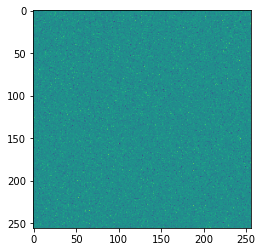

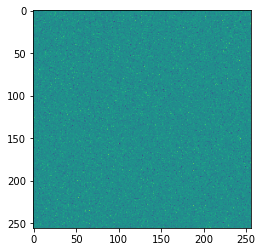

In [38]:
import matplotlib.pyplot as plt

plt.imshow(out[0,0].cpu())
plt.show()
plt.imshow(out2[0,0].cpu())
plt.show()